In [1]:
from pathlib import Path
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch as th
from torch.utils.data import DataLoader, SequentialSampler

import warnings 
warnings.filterwarnings('ignore')

/home/ec2-user/anaconda3/envs/msgifsr/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_dataset(dataset_dir):
    train_path_data=os.path.join(dataset_dir,"train.txt")
    test_path_data=os.path.join(dataset_dir,"test.txt")
    all_train_data=os.path.join(dataset_dir,"all_train_seq.txt")
    all_test_data=os.path.join(dataset_dir,"all_test_seq.txt")
    
    with open(train_path_data,'rb') as f1:
        train_set=pickle.load(f1)
    with open(test_path_data,'rb') as f2:
        test_set=pickle.load(f2)
    with open(all_train_data,'rb') as f3:
        all_train_seq=pickle.load(f3)
    with open(all_test_data,'rb') as f4:
        all_test_seq=pickle.load(f4)
        
    return train_set, test_set, all_train_seq, all_test_seq

In [3]:
data_name="yoochoose1_4"
data_dir='/home/ec2-user/SageMaker/sequence-based-recommendation/YOOCHOOSE_data'
dataset_dir=os.path.join(data_dir, data_name)
train_yoochoose1_4, test_yoochoose1_4, train_seq_yoochoose1_4, test_seq_yoochoose1_4=read_dataset(dataset_dir)

In [4]:
data_name="yoochoose1_64"
data_dir='/home/ec2-user/SageMaker/sequence-based-recommendation/YOOCHOOSE_data'
dataset_dir=os.path.join(data_dir, data_name)
train_yoochoose1_64, test_yoochoose1_64, train_seq_yoochoose1_64, test_seq_yoochoose1_64=read_dataset(dataset_dir)

In [5]:
data_name="diginetica_data"
data_dir='/home/ec2-user/SageMaker/sequence-based-recommendation'
dataset_dir=os.path.join(data_dir, data_name)
train_diginetica, test_diginetica, train_seq_diginetica, test_seq_diginetica=read_dataset(dataset_dir)

In [6]:
data_name="amex_explorepoi-poi_category"
data_dir='/home/ec2-user/SageMaker/sequence-based-recommendation/dataset'
dataset_dir=os.path.join(data_dir, data_name)
train_amex, test_amex, train_seq_amex, test_seq_amex=read_dataset(dataset_dir)

In [7]:
len(train_yoochoose1_64[0]),len(test_yoochoose1_64[0]),len(train_diginetica[0]),len(train_amex[0])

(369859, 55898, 719470, 3536)

In [8]:
def statistics_compute(all_seq,p=50):
    
    lens = np.fromiter(map(len, all_seq), dtype=np.long)
    X=[]
    X.append(np.percentile(lens,p))
    
    result={}
    result['percentile']=X
    result["min"]=[np.min(lens)]
    result["max"]=[np.max(lens)]
    result["mean"]=[np.sum(lens)/lens.shape[0]]
    return result
def unique_items(all_seq):
    items_dict={}
    for seq in all_seq:
        for v in seq:
            items_dict[v]=items_dict.get(v,0)+1
    return len(items_dict)

def click_num(all_seq):
    ctr=0
    for seq in all_seq:
        for v in seq:
            ctr+=1
    return ctr

def avg_gt_lt(all_seq, x=5):
    lens = np.fromiter(map(len, all_seq), dtype=np.long)
    return np.sum(lens>x),  np.sum(lens<=x)

statistical_df=pd.DataFrame()
statistical_df["Datasets"]=["yoochoose 1/64","yoochoose 1/4", "diginetica","amex_poi_category"]
statistical_df["clicks #"]=[click_num(train_seq_yoochoose1_64+test_seq_yoochoose1_64),
                                  click_num(train_seq_yoochoose1_4+test_seq_yoochoose1_4),
                                  click_num(train_seq_diginetica+test_seq_diginetica),
                                 click_num(train_seq_amex+test_seq_amex)]

statistical_df["train sessions"]=[len(train_yoochoose1_64[0]),
                                  len(train_yoochoose1_4[0]),
                                  len(train_diginetica[0]),
                                 len(train_amex[0])]

statistical_df["test sessions"]=[len(test_yoochoose1_64[0]),
                                  len(test_yoochoose1_4[0]),
                                 len(test_diginetica[0]),
                                 len(test_amex[0])]

statistical_df["#length<=5"]=[avg_gt_lt(train_yoochoose1_64[0]+test_yoochoose1_64[0])[1],
                               avg_gt_lt(train_yoochoose1_4[0]+test_yoochoose1_4[0])[1],
                               avg_gt_lt(train_diginetica[0]+test_diginetica[0])[1],
                               avg_gt_lt(train_amex[0]+test_amex[0])[1]]

statistical_df["#length>5"]=[avg_gt_lt(train_yoochoose1_64[0]+test_yoochoose1_64[0])[0],
                               avg_gt_lt(train_yoochoose1_4[0]+test_yoochoose1_4[0])[0],
                               avg_gt_lt(train_diginetica[0]+test_diginetica[0])[0],
                               avg_gt_lt(train_amex[0]+test_amex[0])[0]]

statistical_df["unique item"]=[unique_items(train_yoochoose1_64[0]+test_yoochoose1_64[0]),
                               unique_items(train_yoochoose1_4[0]+test_yoochoose1_4[0]),
                               unique_items(train_diginetica[0]+test_diginetica[0]),
                               unique_items(train_amex[0]+test_amex[0])]

statistical_df["avg length"]=[statistics_compute(train_yoochoose1_64[0]+test_yoochoose1_64[0])['mean'][0],
                               statistics_compute(train_yoochoose1_4[0]+test_yoochoose1_4[0])['mean'][0],
                               statistics_compute(train_diginetica[0]+test_diginetica[0])['mean'][0],
                               statistics_compute(train_amex[0]+test_amex[0])['mean'][0]]

statistical_df["75% quantile"]=[statistics_compute(train_yoochoose1_64[0]+test_yoochoose1_64[0],p=75)['percentile'][0],
                               statistics_compute(train_yoochoose1_4[0]+test_yoochoose1_4[0],p=75)['percentile'][0],
                                statistics_compute(train_diginetica[0]+test_diginetica[0],p=75)['percentile'][0],
                               statistics_compute(train_amex[0]+test_amex[0],p=75)['percentile'][0]]

statistical_df["90% quantile"]=[statistics_compute(train_yoochoose1_64[0]+test_yoochoose1_64[0],p=90)['percentile'][0],
                               statistics_compute(train_yoochoose1_4[0]+test_yoochoose1_4[0],p=90)['percentile'][0],
                                statistics_compute(train_diginetica[0]+test_diginetica[0],p=90)['percentile'][0],
                               statistics_compute(train_amex[0]+test_amex[0],p=90)['percentile'][0]]

statistical_df["max length"]=[statistics_compute(train_yoochoose1_64[0]+test_yoochoose1_64[0])['max'][0],
                               statistics_compute(train_yoochoose1_4[0]+test_yoochoose1_4[0])['max'][0],
                              statistics_compute(train_diginetica[0]+test_diginetica[0])['max'][0],
                               statistics_compute(train_amex[0]+test_amex[0])['max'][0]]

In [9]:
statistical_df.style.format({"clicks #":"{:,}","train sessions":"{:,}","test sessions":"{:,}",\
                             "unique item":"{:,}","#length<=5":"{:,}","#length>5":"{:,}","avg length":"{:.2f}","75% quantile":"{:.0f}",\
                             "90% quantile":"{:.0f}","max length":"{:,}"}).\
set_caption(f"Statistics of datasets used in experiments").set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '15px')
        ]
    }])

,Datasets,clicks #,train sessions,test sessions,#length<=5,#length>5,unique item,avg length,75% quantile,90% quantile,max length
0,yoochoose 1/64,"557,248","369,859","55,898","314,442","111,315","16,766",5.16,6,12,145
1,yoochoose 1/4,"7,911,603","5,917,745","55,898","4,582,811","1,390,832","29,618",4.71,5,10,199
2,diginetica,"982,961","719,470","60,858","591,478","188,850","43,068",4.13,5,9,69
3,amex_poi_category,"4,547","3,536",305,"2,086","1,755",555,8.91,11,22,76


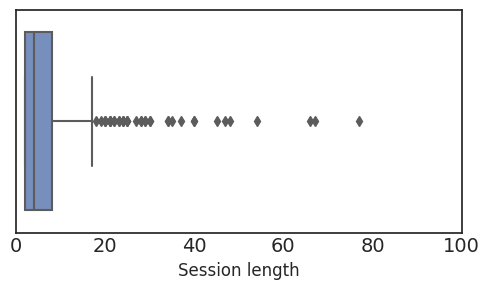

In [7]:
import seaborn as sns
plt.style.use("seaborn-white")
cldr_colors = ['#00b6b5', '#f7955b','#6c8cc7', '#828282']#
cldr_green = '#a4d65d'
color_palette = "viridis"

fig = plt.figure(figsize=(5,3))
plt.xticks(fontsize=14)
lens = np.fromiter(map(len, all_seq), dtype=np.long)
ax = sns.boxplot(x=lens, color=cldr_colors[2])

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
    
plt.xlim(0,100)
plt.xlabel("Session length", fontsize=12);

plt.tight_layout()

In [11]:
def items_count(all_seq):
    items_dict={}
    for seq in all_seq:
        for v in seq:
            items_dict[v]=items_dict.get(v,0)+1
    return items_dict

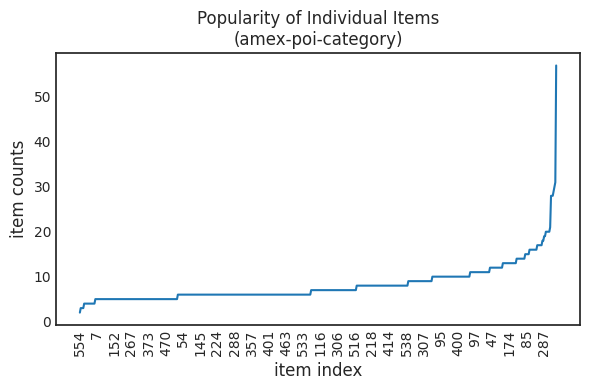

In [12]:
plt.style.use("seaborn-white")
# Number of unique customer IDs

items_dict=items_count(train_seq_amex+test_seq_amex)

item_counts = [v for k,v in items_dict.items()]
item_index = [k for k,v in items_dict.items()]
item_sorted = sorted(zip(item_counts,item_index))

Y=[y for y,_ in item_sorted]
X=[str(x) for _,x in item_sorted]
fig = plt.figure(figsize=(6,4))
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.plot(X,Y)
plt.ylabel("item counts", fontsize=12);
plt.xlabel("item index", fontsize=12);
plt.xticks(np.arange(0, len(X)+1, 20))
plt.xticks(rotation = 90)
plt.title("Popularity of Individual Items\n(amex-poi-category)")
plt.tight_layout()


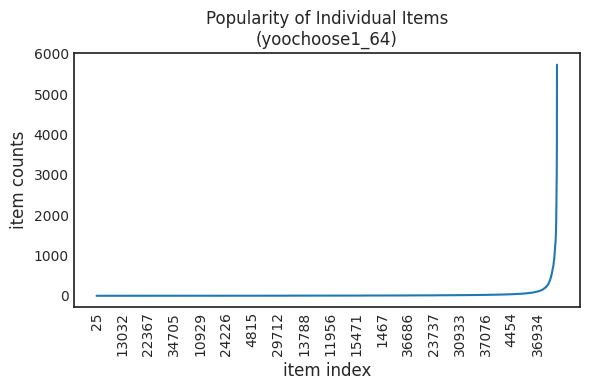

In [13]:
plt.style.use("seaborn-white")
# Number of unique customer IDs

items_dict=items_count(train_seq_yoochoose1_64+test_seq_yoochoose1_64)

item_counts = [v for k,v in items_dict.items()]
item_index = [k for k,v in items_dict.items()]
item_sorted = sorted(zip(item_counts,item_index))

Y=[y for y,_ in item_sorted]
X=[str(x) for _,x in item_sorted]
fig = plt.figure(figsize=(6,4))
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.plot(X,Y)
plt.ylabel("item counts", fontsize=12);
plt.xlabel("item index", fontsize=12);
plt.xticks(np.arange(0, len(X)+1, 1000))
plt.xticks(rotation = 90)
plt.title("Popularity of Individual Items\n(yoochoose1_64)")
plt.tight_layout()


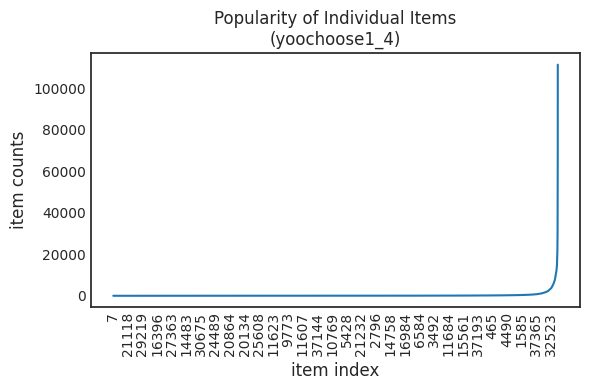

In [14]:
plt.style.use("seaborn-white")
# Number of unique customer IDs

items_dict=items_count(train_seq_yoochoose1_4+test_seq_yoochoose1_4)

item_counts = [v for k,v in items_dict.items()]
item_index = [k for k,v in items_dict.items()]
item_sorted = sorted(zip(item_counts,item_index))

Y=[y for y,_ in item_sorted]
X=[str(x) for _,x in item_sorted]
fig = plt.figure(figsize=(6,4))
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.plot(X,Y)
plt.ylabel("item counts", fontsize=12);
plt.xlabel("item index", fontsize=12);
plt.xticks(np.arange(0, len(X)+1, 1000))
plt.xticks(rotation = 90)
plt.title("Popularity of Individual Items\n(yoochoose1_4)")
plt.tight_layout()

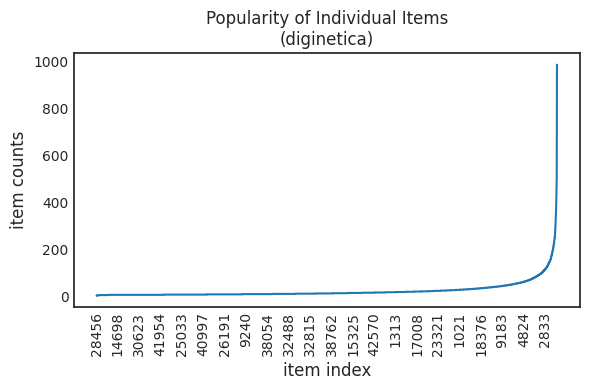

In [18]:
plt.style.use("seaborn-white")
# Number of unique customer IDs

items_dict=items_count(train_seq_diginetica+test_seq_diginetica)

item_counts = [v for k,v in items_dict.items()]
item_index = [k for k,v in items_dict.items()]
item_sorted = sorted(zip(item_counts,item_index))

Y=[y for y,_ in item_sorted]
X=[str(x) for _,x in item_sorted]
fig = plt.figure(figsize=(6,4))
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.plot(X,Y)
plt.ylabel("item counts", fontsize=12);
plt.xlabel("item index", fontsize=12);
plt.xticks(np.arange(0, len(X)+1, 2000))
plt.xticks(rotation = 90)
plt.title("Popularity of Individual Items\n(diginetica)")
plt.tight_layout()